# Results Figure 1 (Binary Experiment)

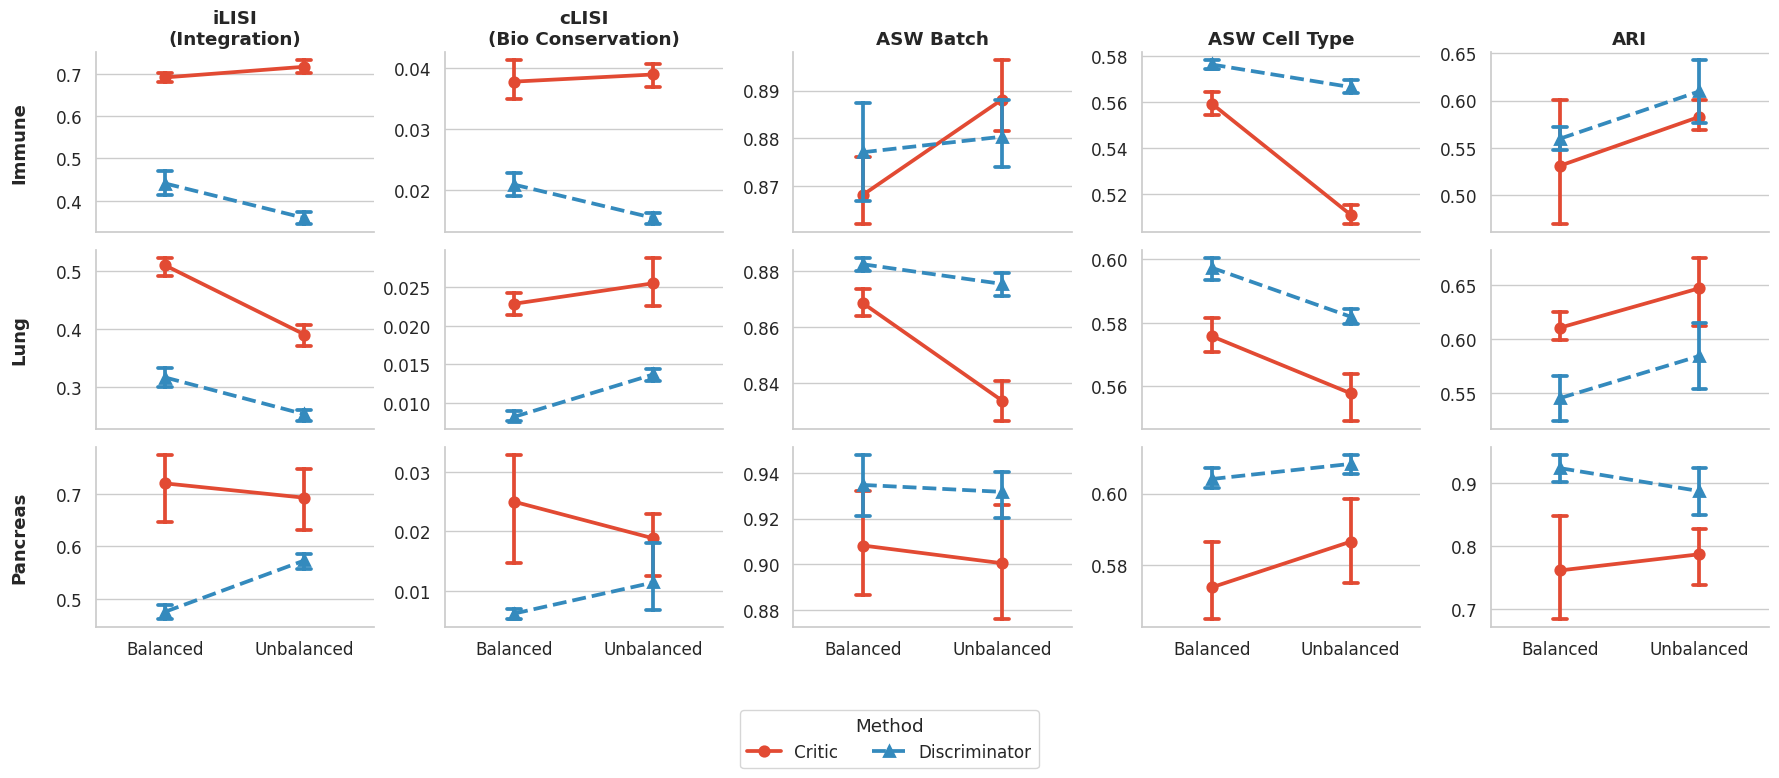

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Data Preparation ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
conditions = ["balanced", "unbalanced"]
datasets = ["immune", "lung", "pancreas"]

data_frames = []

for cond in conditions:
    for ds in datasets:
        file_path = os.path.join(base_dir, cond, f"{ds}_final_best_results.csv")
        
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                df['dataset'] = ds.capitalize()
                df['condition'] = cond.capitalize()
                data_frames.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

if not data_frames:
    raise FileNotFoundError("No result files were found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- UPDATE: Rename Methods for Legend ---
# This ensures the legend uses "Critic" and "Discriminator" naturally
combined_df['method'] = combined_df['method'].map({
    'critic': 'Critic',
    'no_critic': 'Discriminator'
})

# --- 2. Transform Data ---
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'method', 'fold'],
    value_vars=['ilisi', 'clisi', 'asw_batch', 'asw_celltype', 'ari'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)',
    'asw_batch': 'ASW Batch',
    'asw_celltype': 'ASW Cell Type',
    'ari': 'ARI'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.catplot(
    data=long_df,
    x="condition",
    y="score",
    hue="method",
    col="metric_type",
    row="dataset",
    kind="point",
    errorbar=("ci", 95),
    # Update palette to match new names
    palette={"Critic": "#E24A33", "Discriminator": "#348ABD"},
    height=2.5,
    aspect=1.3,
    sharey=False, 
    sharex=True,
    markers=["o", "^"],
    linestyles=["-", "--"],
    capsize=0.1,
    margin_titles=False
)

# --- 4. Customization ---
g.set_axis_labels("", "")
g.set_titles(row_template="", col_template="")

for i, row_axes in enumerate(g.axes):
    for j, ax in enumerate(row_axes):
        if j == 0:
             ax.set_ylabel(g.row_names[i], fontweight='bold', fontsize=13, labelpad=20)
        if i == 0:
            ax.set_title(g.col_names[j], fontweight='bold')
        else:
            ax.set_title("")

# --- 5. Final Layout & Saving ---

# Move legend to the bottom center
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.05), ncol=2, title="Method", frameon=True)

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.15) 

plt.savefig("binary_experiment_comparison.png", dpi=300, bbox_inches='tight')

plt.show()

# Results Figure 2 (muli-batch scaling)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments for results...


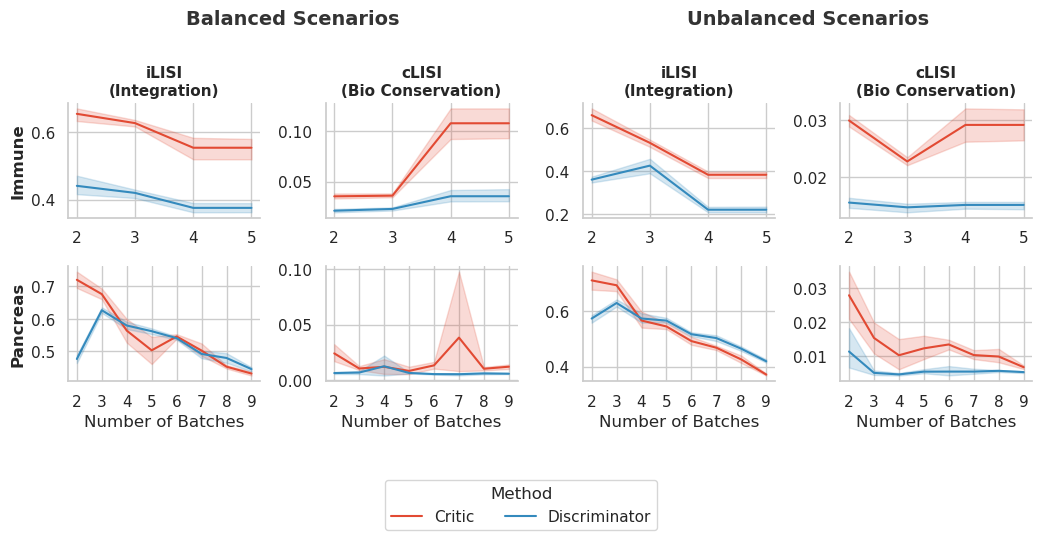

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

if not os.path.exists(base_dir):
    print(f"Warning: Directory {base_dir} not found.")
else:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("_final_best_results.csv"):
                file_path = os.path.join(root, file)
                parts = file_path.split(os.sep)
                try:
                    # Path structure: .../condition/dataset_group/batch_dir/filename
                    batch_folder = parts[-2]
                    condition = parts[-4]
                    n_batches = int(batch_folder.split('_')[-1])
                    
                    if "immune" in batch_folder: dataset_name = "Immune"
                    elif "panc" in batch_folder: dataset_name = "Pancreas"
                    else: dataset_name = "Unknown"

                    df = pd.read_csv(file_path)
                    df['condition'] = condition.capitalize()
                    df['dataset'] = dataset_name
                    df['n_batches'] = n_batches
                    data_frames.append(df)
                except Exception as e:
                    pass

    if not data_frames:
        raise FileNotFoundError("No result files found.")

    combined_df = pd.concat(data_frames, ignore_index=True)

    # --- UPDATE: Rename Methods for Legend ---
    combined_df['method'] = combined_df['method'].map({
        'critic': 'Critic',
        'no_critic': 'Discriminator'
    })

    # --- 2. Data Preparation ---
    long_df = combined_df.melt(
        id_vars=['dataset', 'condition', 'n_batches', 'method', 'fold'],
        value_vars=['ilisi', 'clisi'],
        var_name='metric_type',
        value_name='score'
    )

    metric_renames = {
        'ilisi': 'iLISI\n(Integration)',
        'clisi': 'cLISI\n(Bio Conservation)'
    }
    long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

    # Grouping for 4 columns
    long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
    col_order = [
        f"Balanced\n{metric_renames['ilisi']}", 
        f"Balanced\n{metric_renames['clisi']}",
        f"Unbalanced\n{metric_renames['ilisi']}", 
        f"Unbalanced\n{metric_renames['clisi']}"
    ]

    # --- 3. Plotting ---
    sns.set_theme(style="whitegrid", font_scale=1.0)

    g = sns.relplot(
        data=long_df,
        x="n_batches",
        y="score",
        hue="method",
        col="panel_group",
        row="dataset",
        col_order=col_order,
        kind="line",
        markers=True,
        dashes=False,
        errorbar=("ci", 95),
        # Update palette to match new names
        palette={"Critic": "#E24A33", "Discriminator": "#348ABD"},
        height=2.5,
        aspect=0.9,
        facet_kws={"sharey": False, "sharex": "row"} 
    )

    # --- 4. Customization ---

    # A. BRUTE FORCE CLEAR ALL TITLES
    for ax in g.axes.flatten():
        ax.set_title("")

    # B. Manually set top row titles only
    clean_titles = [
        "iLISI\n(Integration)", 
        "cLISI\n(Bio Conservation)", 
        "iLISI\n(Integration)", 
        "cLISI\n(Bio Conservation)"
    ]

    for ax, title in zip(g.axes[0], clean_titles):
        ax.set_title(title, fontweight='bold', fontsize=11)

    # C. Set Dataset Labels on Y-axis
    g.set_axis_labels("Number of Batches", "")
    for i, row_name in enumerate(g.row_names):
        g.axes[i, 0].set_ylabel(row_name, fontweight='bold', fontsize=12)

    # D. Integer Ticks
    for ax in g.axes.flatten():
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

    # --- 5. Group Subtitles ---
    
    # 1. Reduced top limit (0.92 -> 0.85) to push plots down and create header space
    g.fig.tight_layout(rect=[0, 0.05, 1, 0.85]) 

    def add_group_subtitle(g, col_indices, text, y_offset=0.15): 
        ax_left = g.axes[0, col_indices[0]]
        ax_right = g.axes[0, col_indices[-1]]
        bbox_left = ax_left.get_position()
        bbox_right = ax_right.get_position()
        center_x = (bbox_left.x0 + bbox_right.x1) / 2
        
        # Calculate Y position relative to the top of the axes
        center_y = bbox_left.y1 + y_offset
        
        g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

    add_group_subtitle(g, [0, 1], "Balanced Scenarios")
    add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

    plt.savefig("multibatch_trends_grouped.png", dpi=300, bbox_inches='tight')
    plt.show()

# Results Figure 4 (Reference Batch)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments for results...


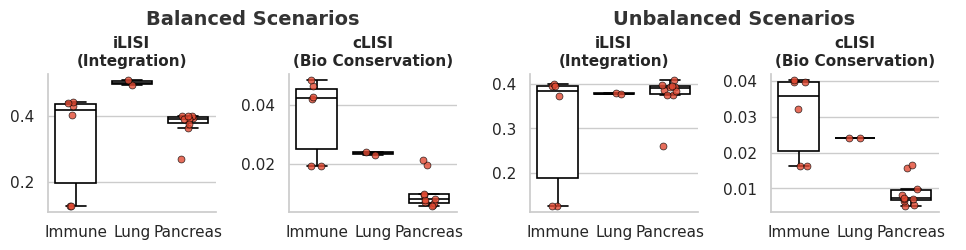

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

if not os.path.exists(base_dir):
    print(f"Warning: Directory {base_dir} not found.")
else:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("_final_best_results.csv"):
                file_path = os.path.join(root, file)
                parts = file_path.split(os.sep)
                try:
                    # Path structure: .../condition/dataset_group/dataset_refIndex/filename
                    batch_folder = parts[-2]
                    dataset_group = parts[-3]
                    condition = parts[-4]
                    
                    ref_index = int(batch_folder.split('_')[-1])
                    
                    if "immune" in dataset_group: dataset_name = "Immune"
                    elif "lung" in dataset_group: dataset_name = "Lung"
                    elif "panc" in dataset_group: dataset_name = "Pancreas"
                    else: dataset_name = "Unknown"

                    df = pd.read_csv(file_path)
                    df['condition'] = condition.capitalize()
                    df['dataset'] = dataset_name
                    df['ref_index'] = ref_index
                    
                    data_frames.append(df)
                except Exception as e:
                    pass

    if not data_frames:
        raise FileNotFoundError("No result files found.")

    combined_df = pd.concat(data_frames, ignore_index=True)

    # --- 2. Filter for CRITIC ONLY ---
    critic_df = combined_df[combined_df['method'] == 'critic'].copy()

    # Average across folds (one point per Reference Batch)
    agg_df = critic_df.groupby(
        ['dataset', 'condition', 'ref_index']
    )[['ilisi', 'clisi']].mean().reset_index()

    # Melt for plotting
    long_df = agg_df.melt(
        id_vars=['dataset', 'condition', 'ref_index'],
        value_vars=['ilisi', 'clisi'],
        var_name='metric_type',
        value_name='score'
    )

    metric_renames = {
        'ilisi': 'iLISI\n(Integration)',
        'clisi': 'cLISI\n(Bio Conservation)'
    }
    long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

    # Grouping
    long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
    col_order = [
        f"Balanced\n{metric_renames['ilisi']}", 
        f"Balanced\n{metric_renames['clisi']}",
        f"Unbalanced\n{metric_renames['ilisi']}", 
        f"Unbalanced\n{metric_renames['clisi']}"
    ]

    # --- 3. Plotting ---
    sns.set_theme(style="whitegrid", font_scale=1.0)

    # We define a single color for the critic since we aren't comparing methods anymore
    critic_color = "#E24A33" 

    g = sns.catplot(
        data=long_df,
        x="dataset",
        y="score",
        col="panel_group",
        col_order=col_order,
        kind="box",
        color="white",    # White box background
        linecolor="black", # Black outline
        height=3.0,
        aspect=0.8,
        sharey=False,
        sharex=True,
        fliersize=0,      # Hide outliers
        linewidth=1.2,
        gap=0.1,
        native_scale=True # Better x-axis handling
    )

    # Overlay individual points (Stripplot)
    # Note: g.axes is a 2D array [[ax1, ax2, ax3, ax4]]
    for i, ax in enumerate(g.axes.flatten()):
        panel_name = col_order[i]
        panel_data = long_df[long_df['panel_group'] == panel_name]
        
        sns.stripplot(
            data=panel_data,
            x="dataset",
            y="score",
            ax=ax,
            color=critic_color, # Use the specific Critic color
            alpha=0.8,
            jitter=0.15,
            size=5,
            edgecolor="black",  # Add a tiny border to dots for clarity
            linewidth=0.5
        )

    # --- 4. Customization ---

    # Clear default titles
    g.set_titles("")
    g.set_axis_labels("", "")

    # Metric Titles (Top Row)
    clean_titles = [
        "iLISI\n(Integration)", 
        "cLISI\n(Bio Conservation)", 
        "iLISI\n(Integration)", 
        "cLISI\n(Bio Conservation)"
    ]
    for ax, title in zip(g.axes[0], clean_titles):
        ax.set_title(title, fontweight='bold', fontsize=11)

    # Group Subtitles
    
    # Push the plot down (0.85 top limit)
    g.fig.tight_layout(rect=[0, 0.05, 1, 0.85]) 

    def add_group_subtitle(g, col_indices, text, y_offset=0.15):
        ax_left = g.axes[0, col_indices[0]]
        ax_right = g.axes[0, col_indices[-1]]
        bbox_left = ax_left.get_position()
        bbox_right = ax_right.get_position()
        center_x = (bbox_left.x0 + bbox_right.x1) / 2
        center_y = bbox_left.y1 + y_offset
        g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

    add_group_subtitle(g, [0, 1], "Balanced Scenarios")
    add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

    # Removed g.fig.suptitle

    plt.savefig("reference_sensitivity_critic_only.png", dpi=300, bbox_inches='tight')
    plt.show()

# Results Figure 3 (Hyperparameter Sensitivity)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments for sensitivity records...


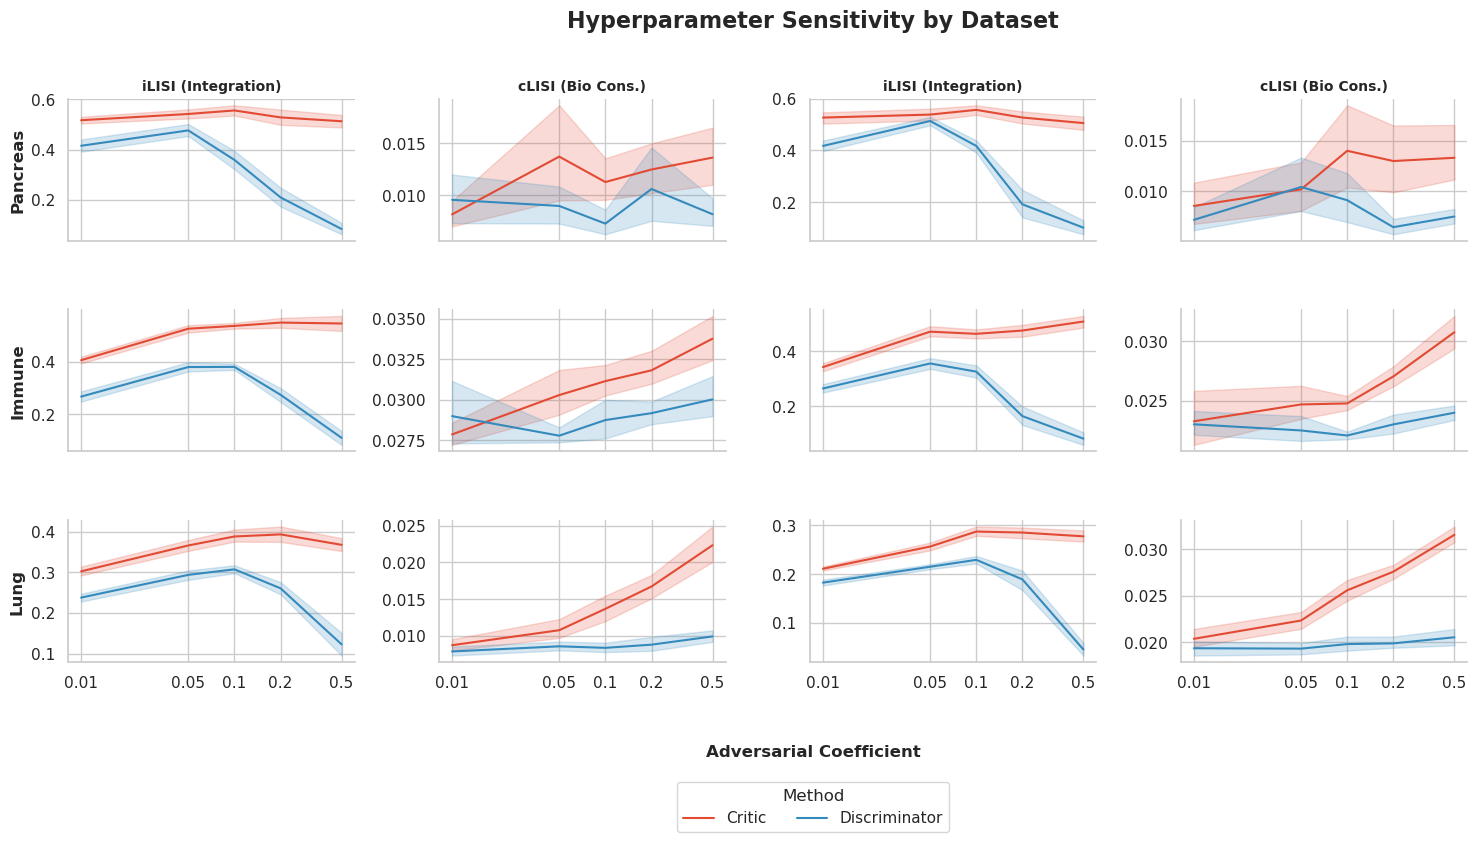

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
data_frames = []

print(f"Scanning {base_dir} for sensitivity records...")

if not os.path.exists(base_dir):
    print("Warning: Base directory not found. Please ensure the path is correct.")
else:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("_comprehensive_sensitivity_records.csv"):
                file_path = os.path.join(root, file)
                parts = file_path.split(os.sep)
                
                try:
                    # Path: .../condition/filename
                    condition = parts[-2] # 'balanced' or 'unbalanced'
                    
                    # Filename: [dataset]_comprehensive_sensitivity_records.csv
                    dataset_name_raw = file.split('_comprehensive')[0]
                    
                    if "immune" in dataset_name_raw: dataset_name = "Immune"
                    elif "lung" in dataset_name_raw: dataset_name = "Lung"
                    elif "panc" in dataset_name_raw: dataset_name = "Pancreas"
                    else: dataset_name = "Unknown"

                    df = pd.read_csv(file_path)
                    
                    # Filter for INNER VALIDATION data only
                    df = df[df['data_type'] == 'inner_validation_raw'].copy()
                    
                    df['condition'] = condition.capitalize()
                    df['dataset'] = dataset_name
                    
                    data_frames.append(df)
                except Exception as e:
                    pass

    if not data_frames:
        raise FileNotFoundError("No sensitivity records found.")

    combined_df = pd.concat(data_frames, ignore_index=True)

    # --- UPDATE: Rename Methods for Legend ---
    combined_df['method'] = combined_df['method'].map({
        'critic': 'Critic',
        'no_critic': 'Discriminator'
    })

    # --- 2. Data Preparation ---
    long_df = combined_df.melt(
        id_vars=['dataset', 'condition', 'd_coef', 'method', 'outer_fold', 'inner_fold'],
        value_vars=['ilisi', 'clisi'],
        var_name='metric_type',
        value_name='score'
    )

    metric_renames = {
        'ilisi': 'iLISI\n(Integration)',
        'clisi': 'cLISI\n(Bio Conservation)'
    }
    long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

    # Create Panel Grouping for Columns
    long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']

    # Define Orders
    col_order = [
        f"Balanced\n{metric_renames['ilisi']}", 
        f"Balanced\n{metric_renames['clisi']}",
        f"Unbalanced\n{metric_renames['ilisi']}", 
        f"Unbalanced\n{metric_renames['clisi']}"
    ]
    
    dataset_order = ["Pancreas", "Immune", "Lung"] 

    # --- 3. Plotting ---
    sns.set_theme(style="whitegrid", font_scale=1.0)

    g = sns.relplot(
        data=long_df,
        x="d_coef",
        y="score",
        hue="method",
        col="panel_group",
        row="dataset",
        row_order=dataset_order,
        col_order=col_order,
        kind="line",
        markers=True,
        dashes=False,
        errorbar=("ci", 95),
        # Update palette to match new names
        palette={"Critic": "#E24A33", "Discriminator": "#348ABD"},
        height=2.5,
        aspect=1.5,
        facet_kws={"sharey": False, "sharex": True, "margin_titles": False}
    )

    # --- 4. Customization ---

    # Set X-axis to Log Scale
    g.set(xscale="log")

    # Clear default titles and labels
    g.set_titles("") 
    g.set_axis_labels("", "") 

    # --- Set Dataset Name as Y-Axis Label ---
    for i, dataset_name in enumerate(dataset_order):
        g.axes[i, 0].set_ylabel(dataset_name, fontweight='bold', fontsize=12)

    # --- Set X-Axis Label Once at the Bottom ---
    g.fig.supxlabel("Adversarial Coefficient", fontsize=12, fontweight='bold', y=0.02)
    g.fig.subplots_adjust(bottom=0.15)

    # Fix X-Axis Ticks with Custom Formatting
    d_coef_values = [0.01, 0.05, 0.1, 0.2, 0.5]
    
    # Use FuncFormatter with 'g' format to remove trailing zeros
    formatter = FuncFormatter(lambda x, pos: '{:g}'.format(x))

    for ax in g.axes.flatten():
        ax.set_xticks(d_coef_values)
        ax.get_xaxis().set_major_formatter(formatter)
        ax.minorticks_off()

    # Top row titles
    clean_titles = [
        "iLISI (Integration)", 
        "cLISI (Bio Cons.)", 
        "iLISI (Integration)", 
        "cLISI (Bio Cons.)"
    ]
    
    for i, ax in enumerate(g.axes[0]):
        ax.set_title(clean_titles[i], fontweight='bold', fontsize=10)

    # Move legend
    sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

    # Add Super Title
    g.fig.suptitle("Hyperparameter Sensitivity by Dataset", y=1.02, fontsize=16, fontweight='bold')

    plt.savefig("d_coef_sensitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Table 1: Corrected paired t-test for binary

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os

def calculate_corrected_paired_t_stats(a, b, n_folds=5, test_train_ratio=0.25):
    """
    Performs a paired t-test corrected for cross-validation overlap (Nadeau & Bengio 2003).
    """
    diff = a - b
    n = len(diff)
    
    # Calculate Mean Difference
    mean_diff = np.mean(diff)
    
    # Calculate Sample Variance of the Differences
    var_diff = np.var(diff, ddof=1) 
    
    # --- NADEAU & BENGIO CORRECTION ---
    correction_factor = (1/n) + test_train_ratio
    corrected_variance_of_mean = var_diff * correction_factor
    std_err_corrected = np.sqrt(corrected_variance_of_mean)
    
    # Calculate t-statistic using corrected SE
    if std_err_corrected == 0:
        t_stat = 0.0
        p_value = 1.0
    else:
        t_stat = mean_diff / std_err_corrected
        dof = n - 1
        p_value = 2 * stats.t.sf(np.abs(t_stat), dof)
    
    return mean_diff, t_stat, p_value

def format_p_value(p_value):
    """Formats p-values to scientific notation or fixed decimal."""
    if p_value < 0.001:
        return f"{p_value:.2e}" 
    else:
        return f"{p_value:.4f}"

def get_stats_for_condition(condition, dataset_name, metric_col, base_dir, n_folds, ratio):
    """
    Helper to load data and calculate stats for a specific condition/dataset/metric.
    Returns a tuple of strings: (Critic Mean(SD), Discrim Mean(SD), p-value)
    """
    current_dir = os.path.join(base_dir, condition)
    filename = f"{dataset_name.lower()}_final_best_results.csv"
    filepath = os.path.join(current_dir, filename)
    
    if not os.path.exists(filepath):
        return "N/A", "N/A", "N/A"
        
    df = pd.read_csv(filepath)
    
    if metric_col not in df.columns or 'method' not in df.columns:
        return "N/A", "N/A", "N/A"

    # Pivot to get paired columns: index=fold, columns=method
    pivot_df = df.pivot(index='fold', columns='method', values=metric_col)
    
    if 'critic' not in pivot_df.columns or 'no_critic' not in pivot_df.columns:
        return "N/A", "N/A", "N/A"

    # Calculate Stats
    mean_c = pivot_df['critic'].mean()
    std_c = pivot_df['critic'].std()
    mean_d = pivot_df['no_critic'].mean()
    std_d = pivot_df['no_critic'].std()
    
    # Calculate Corrected T-Test
    _, _, p_val = calculate_corrected_paired_t_stats(
        pivot_df['critic'], pivot_df['no_critic'], 
        n_folds=n_folds, test_train_ratio=ratio
    )
    
    str_critic = f"{mean_c:.3f} ({std_c:.3f})"
    str_discrim = f"{mean_d:.3f} ({std_d:.3f})"
    str_pval = format_p_value(p_val)
    
    return str_critic, str_discrim, str_pval

# --- 1. Configuration ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
output_tex_file = "binary_ttest_compact.tex"

datasets = ["Pancreas", "Immune", "Lung"]

# Metrics to analyze
metric_map = {
    'ilisi': 'iLISI',
    'asw_batch': 'ASW Batch',
    'clisi': 'cLISI',
    'asw_celltype': 'ASW Cell',
    'ari': 'ARI'
}

# Parameters for Correction (5-Fold CV)
N_FOLDS = 5
RATIO = 1.0 / (N_FOLDS - 1)

# --- 2. Process Datasets ---
table_rows = []

print(f"Scanning {base_dir}...")

for i, title in enumerate(datasets):
    # Add Dataset Header Row
    # We leave empty cells for the data columns
    table_rows.append(f"\\textbf{{{title}}} & & & & & & & \\\\")
    
    # Iterate through metrics
    for metric_col, metric_display in metric_map.items():
        
        # Get Unbalanced Stats
        u_crit, u_disc, u_p = get_stats_for_condition(
            "unbalanced", title, metric_col, base_dir, N_FOLDS, RATIO
        )
        
        # Get Balanced Stats
        b_crit, b_disc, b_p = get_stats_for_condition(
            "balanced", title, metric_col, base_dir, N_FOLDS, RATIO
        )
        
        # Format the combined row
        # Structure: Metric & Unbal_Critic & Unbal_Disc & Unbal_P & Bal_Critic & Bal_Disc & Bal_P \\
        row_str = (
            f" & {metric_display} & "
            f"{u_crit} & {u_disc} & {u_p} & "
            f"{b_crit} & {b_disc} & {b_p} \\\\"
        )
        table_rows.append(row_str)
    
    # Add spacing between datasets, but not after the last one
    if i < len(datasets) - 1:
        table_rows.append("\\addlinespace")

# --- 3. Generate LaTeX File ---
latex_header = [
    "\\begin{table*}[t!]",
    "\\centering",
    "\\caption{Statistical Comparison: Wasserstein Critic vs. Discriminator across Unbalanced and Balanced Scenarios.}",
    "\\label{tab:ttest_results_compact}",
    "\\setlength{\\tabcolsep}{4pt}",
    "\\begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill}} l l r r r r r r }",
    "\\toprule",
    " & & \\multicolumn{3}{c}{\\textbf{Unbalanced Scenario}} & \\multicolumn{3}{c}{\\textbf{Balanced Scenario}} \\\\",
    "\\cmidrule(lr){3-5} \\cmidrule(lr){6-8}",
    "Dataset & Metric & Critic (SD) & Discrim (SD) & p-value & Critic (SD) & Discrim (SD) & p-value \\\\",
    "\\midrule"
]

latex_footer = [
    "\\bottomrule",
    "\\multicolumn{8}{l}{\\footnotesize *Corrected for CV overlap (Nadeau \\& Bengio, 2003)}",
    "\\end{tabular*}",
    "\\end{table*}"
]

with open(output_tex_file, "w") as f:
    f.write("\n".join(latex_header) + "\n")
    for row in table_rows:
        f.write(row + "\n")
    f.write("\n".join(latex_footer))

print(f"\nResults saved to {output_tex_file}")

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments...

Results saved to binary_ttest_compact.tex


# Exploratory Data

In [6]:
def generate_combined_adata_table(
    adata_list, 
    protocol_keys, 
    save_path,
    dataset_names= None,
    tech_name_map= None
) -> str:
    """
    Generates a single, combined, and centered LaTeX table and saves it to a file.

    The table lists each dataset, its technologies (with names mapped if provided), 
    a sub-total, and a grand total.

    Args:
        adata_list: A list of loaded AnnData objects.
        protocol_keys: A list of strings, where each string is the .obs key 
                         for the protocol in the corresponding AnnData object.
        save_path: The file path to write the .tex file (e.g., "my_table.tex").
        dataset_names: An optional list of strings to name each dataset.
        tech_name_map: An optional dictionary to map raw technology names
                         (e.g., "10x_v3") to display names (e.g., "10x Chromium v3").

    Returns:
        The LaTeX table as a string.
    """
    
    # --- 1. Input Validation ---
    if len(adata_list) != len(protocol_keys):
        raise ValueError(
            "The 'adata_list' and 'protocol_keys' must have the same length."
        )
        
    if dataset_names and len(dataset_names) != len(adata_list):
        raise ValueError(
            "The 'dataset_names' list must have the same length as 'adata_list'."
        )

    # --- 2. Build Table Data Row-by-Row ---
    table_data = []
    grand_total_cells = 0
    
    for i, (adata, key) in enumerate(zip(adata_list, protocol_keys)):
        
        # Get dataset name
        name = dataset_names[i] if dataset_names else f"Dataset {i + 1}"
        
        # Add the dataset name row (in bold)
        table_data.append({
            "Source": f"\\textbf{{{name}}}",
            "Cell Count": None 
        })
        
        if key not in adata.obs.columns:
            print(f"Warning: Key '{key}' not found in {name}. Skipping dataset.")
            table_data.append({"Source": f"  (Error: Key '{key}' not found)", "Cell Count": 0})
            continue

        # Get counts for each tech
        tech_counts = adata.obs[key].value_counts().sort_index()
        
        # Add a row for each technology (indented)
        for original_tech_name, count in tech_counts.items():
            
            # --- Use the tech_name_map if provided ---
            display_tech_name = original_tech_name # Default
            if tech_name_map:
                # .get() safely defaults to the original name if key is not in map
                display_tech_name = tech_name_map.get(original_tech_name, 
                                                      original_tech_name)
            
            table_data.append({
                "Source": f"  {display_tech_name}", # Indent with spaces
                "Cell Count": count
            })
            
        # Add dataset sub-total
        dataset_total = tech_counts.sum()
        table_data.append({
            "Source": f"  \\textbf{{Total}}",
            "Cell Count": dataset_total
        })
        
        grand_total_cells += dataset_total
        
        # Add a blank spacer row
        if i < len(adata_list) - 1:
             table_data.append({"Source": "", "Cell Count": None})

    # --- 3. Add Grand Total ---
    table_data.append({
        "Source": "\\textbf{Grand Total}",
        "Cell Count": grand_total_cells
    })
    
    # --- 4. Create DataFrame and Format ---
    df = pd.DataFrame(table_data)
    
    df["Cell Count"] = df["Cell Count"].apply(
        lambda x: f"{x:,.0f}" if pd.notnull(x) else ""
    )

    # --- 5. Generate LaTeX String ---
    # We use position="h!" for a strong "here" preference
    latex_table_raw = df.to_latex(
        index=False,
        caption="Combined cell counts by dataset and technology.",
        label="tab:combined_counts",
        position="h!", 
        column_format="lr", # Left-align Source, Right-align Cell Count
        escape=False       # Renders \textbf{} correctly
    )
    
    # --- Insert \centering command ---
    # The default output of to_latex() is missing \centering.
    # We add it right after the \begin{table}[h!] line.
    latex_table = latex_table_raw.replace(
        r"\begin{table}[h!]",
        r"\begin{table}[h!]" + "\n" + r"\centering",
        1 # Only replace the first instance
    )
    
    # --- 6. Save to File ---
    try:
        with open(save_path, "w") as f:
            f.write(latex_table)
        print(f"✅ Successfully wrote centered LaTeX table to: {save_path}")
    except Exception as e:
        print(f"Error: Could not write to file {save_path}. {e}")
        
    return latex_table

In [7]:
pancreas_adata, _ = prep_data("/workspaces/data/human_pancreas_norm_complexBatch.h5ad", 
                  batch_key="tech", 
                  celltype_key="celltype",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

lung_adata, _ = prep_data("/workspaces/data/Lung_atlas_public.h5ad", 
                  batch_key="protocol", 
                  celltype_key="cell_type",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

immune_adata, _ = prep_data("/workspaces/data/Immune_ALL_human.h5ad", 
                  batch_key="chemistry", 
                  celltype_key="final_annotation",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/opt/conda/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/scCRAFT/utils.py:193: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg

Final preprocessed data has 16382 cells.
The largest batch in the final dataset is: 'inDrop3'


/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Final preprocessed data has 29256 cells.
The largest batch in the final dataset is: '10x v2'


/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Final preprocessed data has 33506 cells.
The largest batch in the final dataset is: 'v2_10X'


In [8]:
tech_map = {
    "inDrop3": "inDrop-Seq",
    "smartseq2": "Smart-Seq",
    "10x v2": "10x Chromium",
    "drop-seq": "Drop-Seq",
    "v3_10X": "10x Chromium v3",
    "v2_10X": "10x Chromium v2",
}

generate_combined_adata_table(
    adata_list=[pancreas_adata, lung_adata, immune_adata], 
    protocol_keys=['tech', 'protocol', 'chemistry'], 
    dataset_names=['Pancreas Dataset', 'Lung Dataset', 'Immune Dataset'],
    save_path="/workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex",
    tech_name_map=tech_map
)

✅ Successfully wrote centered LaTeX table to: /workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex


'\\begin{table}[h!]\n\\centering\n\\caption{Combined cell counts by dataset and technology.}\n\\label{tab:combined_counts}\n\\begin{tabular}{lr}\n\\toprule\nSource & Cell Count \\\\\n\\midrule\n\\textbf{Pancreas Dataset} &  \\\\\n  celseq & 1,004 \\\\\n  celseq2 & 2,285 \\\\\n  fluidigmc1 & 638 \\\\\n  inDrop1 & 1,937 \\\\\n  inDrop2 & 1,724 \\\\\n  inDrop-Seq & 3,605 \\\\\n  inDrop4 & 1,303 \\\\\n  smarter & 1,492 \\\\\n  Smart-Seq & 2,394 \\\\\n  \\textbf{Total} & 16,382 \\\\\n &  \\\\\n\\textbf{Lung Dataset} &  \\\\\n  10x Chromium & 22,771 \\\\\n  Drop-Seq & 6,485 \\\\\n  \\textbf{Total} & 29,256 \\\\\n &  \\\\\n\\textbf{Immune Dataset} &  \\\\\n  10X & 8,829 \\\\\n  smart-seq2 & 1,022 \\\\\n  10x Chromium v2 & 12,928 \\\\\n  10x Chromium v3 & 10,727 \\\\\n  \\textbf{Total} & 33,506 \\\\\n\\textbf{Grand Total} & 79,144 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'